In [1]:
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.decomposition import PCA, TruncatedSVD

from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

import io
import gensim
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, davies_bouldin_score
from sklearn.linear_model import LogisticRegression
import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Only uncomment if using data from the google drive
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('drive/My Drive/Vector') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### The chosen dataset includes tweets about disasters, e.g., earthquake, wildfire. The target value is encoded as 1 and 0 where 1 means real disaster and 0 means fake disaster news. The objective is to process the tweets using different word embeddings and compare the results.

In [3]:
# Read the data
df = pd.read_csv('train.csv')

In [4]:
# Check different classes
df[df['target']==1].head(5)

text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

In [5]:
df[df['target']==0].tail(5)

text  target
7581  @engineshed Great atmosphere at the British Li...       0
7582  Cramer: Iger's 3 words that wrecked Disney's s...       0
7584  These boxes are ready to explode! Exploding Ki...       0
7587                                 Sirens everywhere!       0
7593  I just heard a really loud bang and everyone i...       0

# Cleaning the texts

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
DIGITS = re.compile('[\b\d+\b]')

# Make a set of the stopwords from stopwords.txt
with open('stopwords.txt', 'r') as st:
  st_content = st.read()
  STOPWORDS = set(st_content.split())

def clean_text(text):
    """
    text: string
    return: processed string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = DIGITS.sub('', text) # delete symbols which are in DIGITS from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['text'] = df['text'].apply(clean_text)

In [7]:
# Check the processed dataframe
df[df['target']==1].head(5)

text  target
0              deeds reason earthquake allah forgive       1
1              forest fire near la ronge sask canada       1
2  residents shelter notified officers evacuation...       1
3     people receive wildfires evacuation california       1
4  sent photo ruby alaska smoke wildfires pours s...       1

In [8]:
df[df['target']==0].tail(5)

text  target
7581  engineshed atmosphere british lion gig tonight...       0
7582  cramer igers words wrecked disneys stock cnbc ...       0
7584  boxes ready explode exploding kittens finally ...       0
7587                                             sirens       0
7593                             heard loud bang asleep       0

In [9]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.2, random_state=RANDOM_SEED)

# Tokenizing the texts

In [10]:
def create_corpus_new(text_in):
    """
    This method is used to tokenize the corpus
    """
    corpus=[]
    for q in tqdm(text_in):
        sentence = nlp(q)
        words = [i.text for i in sentence]
        corpus.append(words)
    return corpus   

# Apply tokenization
corpus_train = create_corpus_new(X_train)
corpus_test = create_corpus_new(X_test)


100%|██████████| 1523/1523 [00:13<00:00, 116.03it/s]


# Helper methods for visualizing and evaluating performance

In [11]:
# Ref: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
# Use LSA - Latent Semantic Analysis to visualize vectors
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
  """
  This method plots the higher deminsion features into 2d space.
  """
  lsa = TruncatedSVD(n_components=2) # Singular Value Decomposition
  lsa.fit(test_data)
  lsa_scores = lsa.transform(test_data)
  color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
  color_column = [color_mapper[label] for label in test_labels]
  colors = ['red','blue']
  if plot:
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=40, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color='red', label='Fake Disaster')
    blue_patch = mpatches.Patch(color='blue', label='Real Disaster')
    plt.legend(handles=[red_patch, blue_patch], prop={'size': 30})
  
def evaluate_embedding(X_train, y_train, X_test, y_test):
  """
  This method calculates accuracy (logistic regression), 
  davies bouldin index, and silhouette index of the model. 

  """
  model = LogisticRegression(n_jobs=1, C=1e4, max_iter=1000)
  model = model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  result = accuracy_score(y_pred, y_test)
  db_in = davies_bouldin_score(X_train, y_train)
  sil_in = silhouette_score(X_train, y_train)
  print(classification_report(y_test, y_pred,target_names=['Fake','Real']))
  return result, db_in, sil_in

# Word2Vec Embedding

In [12]:
# Using pretrained google word2vec model (trained on 100 billion word Google News corpus)
# Downlaoded from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
def word_averaging(wv, words):
    """
    This method is used to average the word vectors
    """
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [14]:
# Averaging vectors
X_train_word_average = word_averaging_list(wv,corpus_train)
X_test_word_average = word_averaging_list(wv,corpus_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [15]:
# Check the embedding
X_train_word_average[:5]

array([[ 0.04512615,  0.03690424,  0.04612451, ..., -0.09547178,
        -0.05786175,  0.04199634],
       [ 0.07026597,  0.0493657 ,  0.02726102, ..., -0.06384195,
        -0.11806512,  0.02027735],
       [ 0.00422908,  0.07482392,  0.08008473, ..., -0.06859224,
         0.00982279,  0.03813032],
       [ 0.01515704,  0.0684289 , -0.05300612, ...,  0.03058991,
         0.073898  , -0.00339151],
       [-0.000711  ,  0.02030352,  0.08978957, ..., -0.01471669,
        -0.04210019,  0.09132063]])

In [16]:
# plot the embeddings in 2D space
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_word_average, y_train)
plt.show()

By analyzing the 2D plot for word2vec this is very difficult to say if the classes are linearly separable. It seems like the data for the classes are overlapping.

In [17]:
#Evualte model
accuracy, db_in, sil_in = evaluate_embedding(X_train_word_average, y_train, X_test_word_average, y_test)
# Save results
data = {'model': 'Word2Vec', 'accuracy': accuracy, 'davies bouldin index':db_in, 'silhouette index':sil_in}
df_performance = pd.DataFrame(data, index=[0])

              precision    recall  f1-score   support

        Fake       0.81      0.86      0.83       874
        Real       0.79      0.73      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



# GloVe Embedding

In [18]:
# Reading the pre-trained data and making a dictionary 
# Data downloaded from https://nlp.stanford.edu/projects/glove/
embedding_dict={}
with open('glove.6B.300d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [19]:
def word_averaging_glove(dictionary, words):
    """
    This method is used to average the word vectors
    """
    all_words, mean = set(), []
    for word_list in words:
        for word in word_list:
            if isinstance(word, np.ndarray):
                mean.append(word)
            elif word in dictionary.keys():        
                mean.append(dictionary[word])
    if not mean:
        return np.zeros(300,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list_glove(dictionary, text_list):
    return np.vstack([word_averaging_glove(dictionary, post) for post in text_list ])

In [20]:
X_train_embeddings_glove = word_averaging_list_glove(embedding_dict, corpus_train)
X_test_embeddings_glove = word_averaging_list_glove(embedding_dict, corpus_test)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


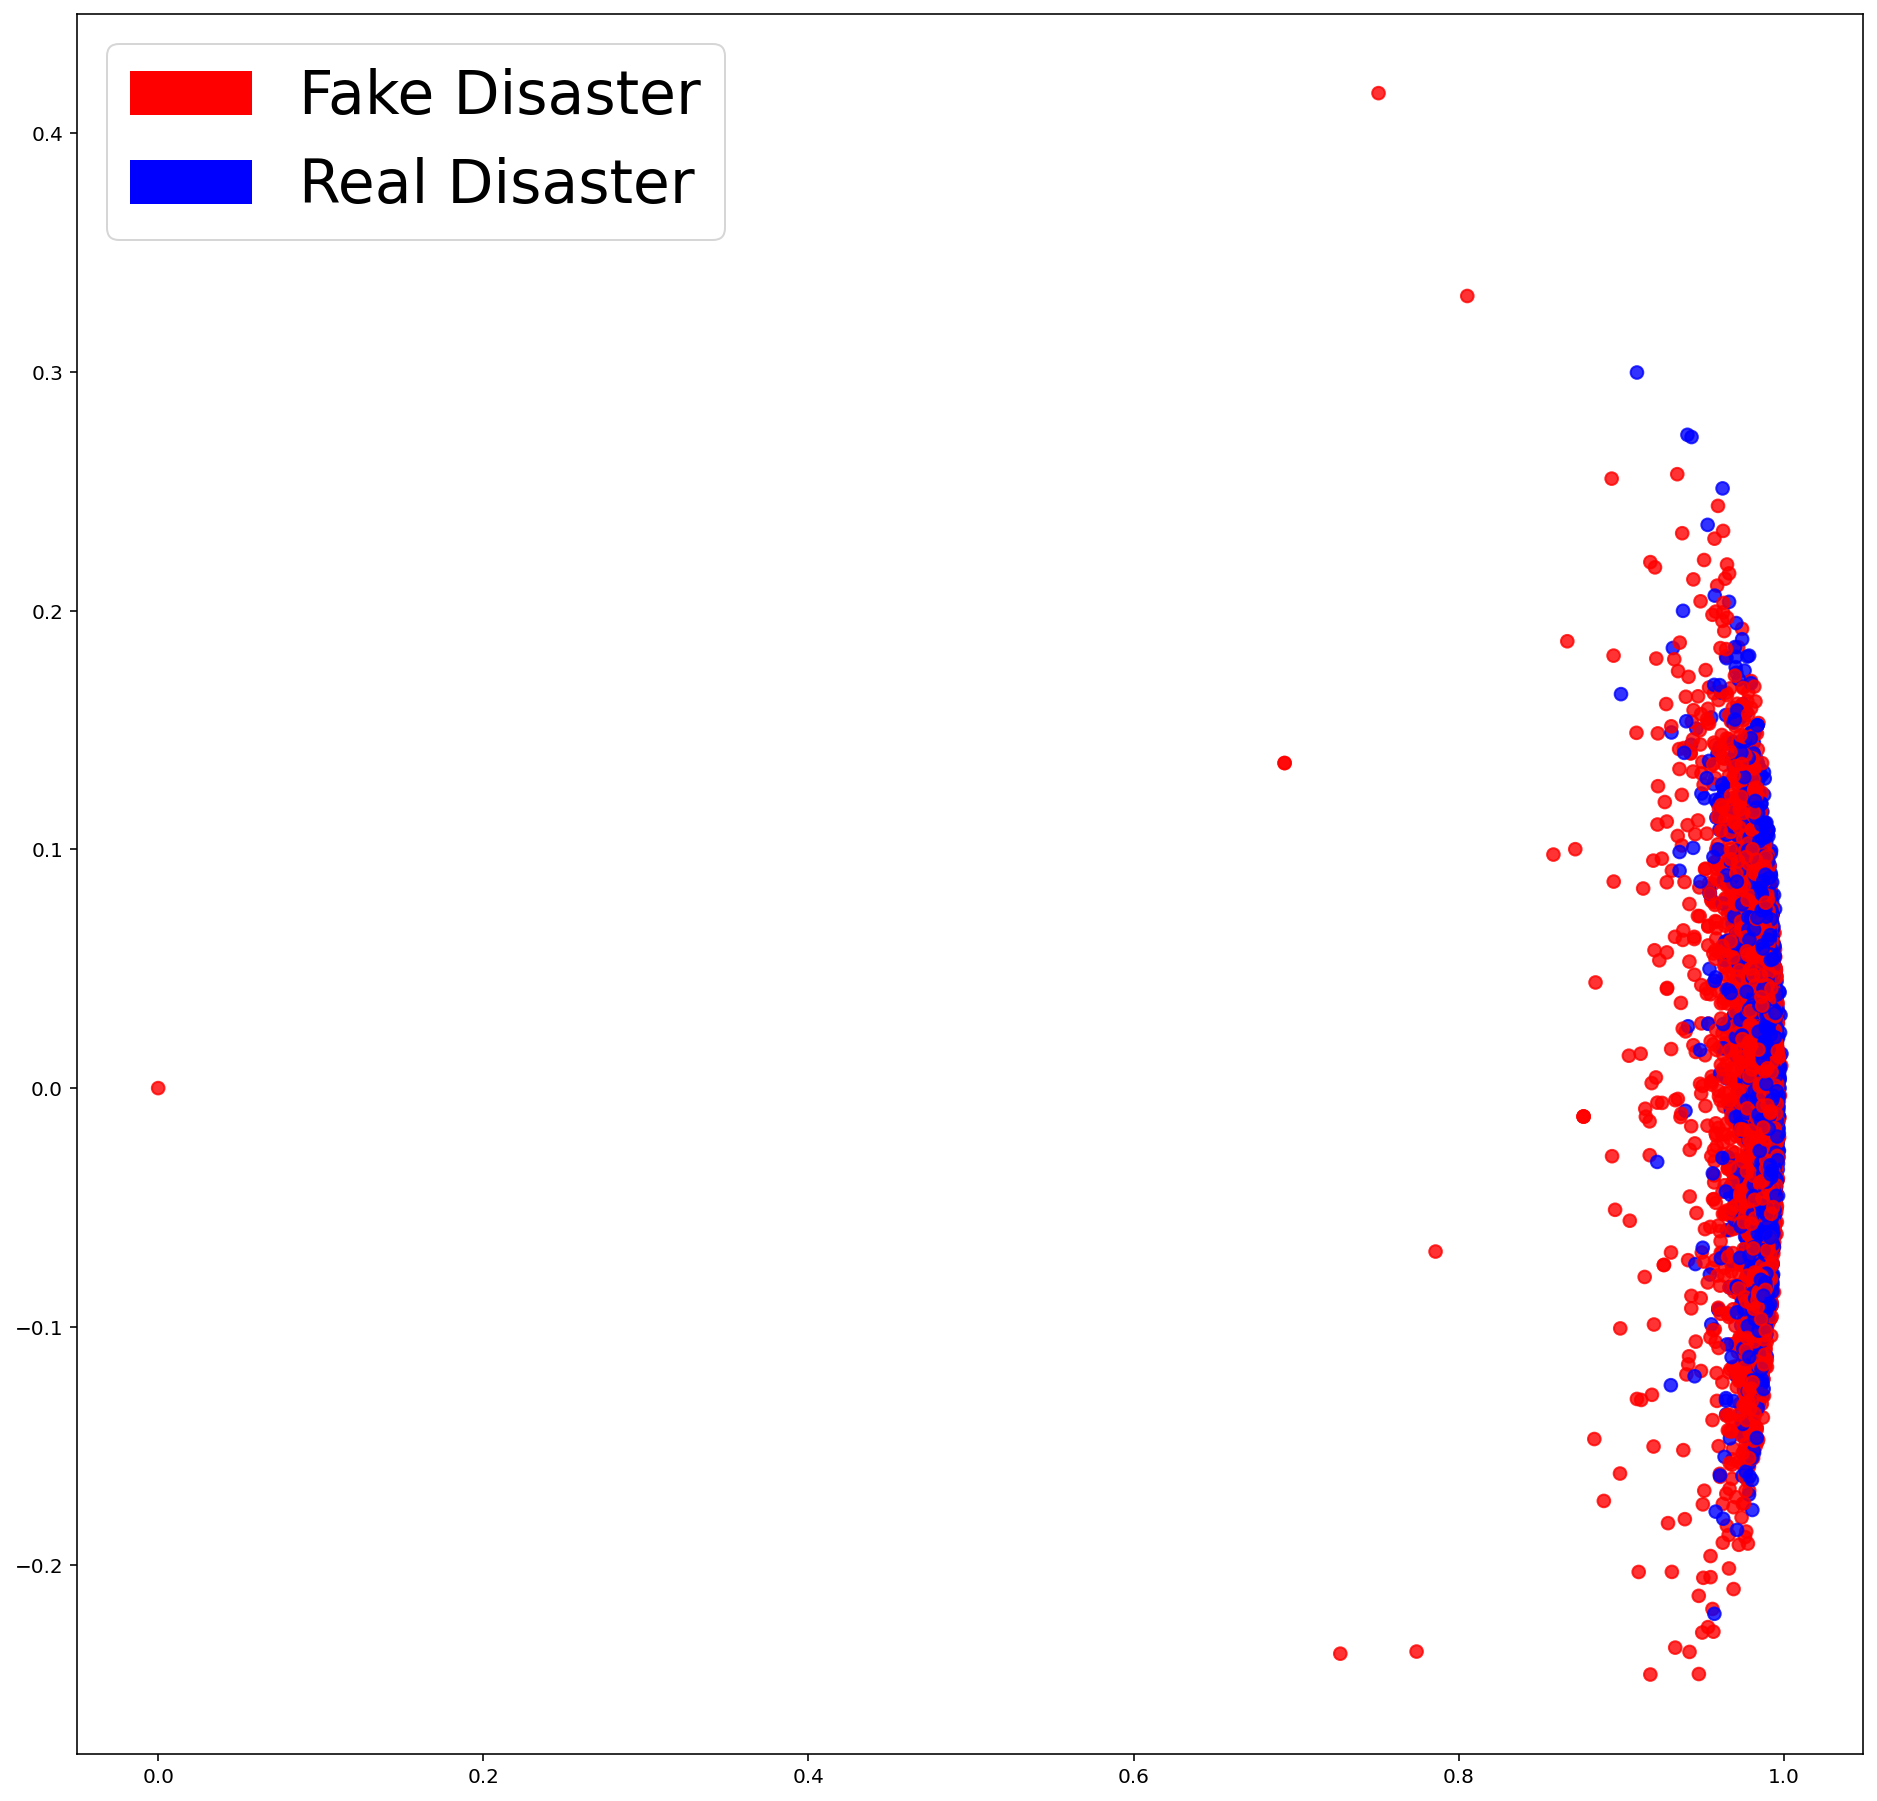

In [21]:
# plot the embeddings in 2D space
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_embeddings_glove, y_train)
plt.show()

The GloVe embeddings seem to make the classes more ceoncentrated. Therefore, the linear separation is challenging. Let's see how our model performs in the classification task.

In [22]:
#Evualte model
accuracy, db_in, sil_in = evaluate_embedding(X_train_embeddings_glove, y_train, X_test_embeddings_glove, y_test)
# Save results
data = {'model': 'GloVe', 'accuracy': accuracy, 'davies bouldin index':db_in, 'silhouette index':sil_in}
df_performance = df_performance.append(data, ignore_index=True)

              precision    recall  f1-score   support

        Fake       0.65      0.74      0.70       874
        Real       0.57      0.47      0.52       649

    accuracy                           0.63      1523
   macro avg       0.61      0.61      0.61      1523
weighted avg       0.62      0.63      0.62      1523



# FastText Embedding

In [23]:
# Reading the pre-trained data and making a dictionary 
# Data downloaded from https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:],'float32')
    return data

embedding_dict_fast = load_vectors('wiki.simple.vec')

In [24]:
def word_averaging_fast(dictionary, words):
    """
    This method is used to average the word vectors
    """
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in dictionary.keys():        
            mean.append(list(dictionary[word]))

    if not mean:
        return np.zeros(300,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list_fast(dictionary, text_list):
    return np.vstack([word_averaging_fast(dictionary, post) for post in text_list ])

In [25]:
X_train_embeddings_fast = word_averaging_list_fast(embedding_dict_fast, corpus_train)
X_test_embeddings_fast = word_averaging_list_fast(embedding_dict_fast, corpus_test)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [26]:
# plot the embeddings in 2D space
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_embeddings_fast, y_train)
plt.show()

The FastText embeddings seem to make a difference. The classes are now more clear. The separation can be visually seen.

In [27]:
#Evualte model
accuracy, db_in, sil_in = evaluate_embedding(X_train_embeddings_fast, y_train, X_test_embeddings_fast, y_test)
# Save results
data = {'model': 'FastText', 'accuracy': accuracy, 'davies bouldin index':db_in, 'silhouette index':sil_in}
df_performance = df_performance.append(data, ignore_index=True)

              precision    recall  f1-score   support

        Fake       0.81      0.85      0.83       874
        Real       0.78      0.73      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



# LexVec Embedding

In [28]:
# Reading the pre-trained data and making a dictionary 
# Data downloaded from https://github.com/alexandres/lexvec
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:],'float32')
    return data

embedding_dict_lex = load_vectors('lexvec.enwiki+newscrawl.300d.W.pos.vectors')

In [29]:
def word_averaging_lex(dictionary, words):
    """
    This method is used to average the word vectors
    """
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in dictionary.keys():        
            mean.append(list(dictionary[word]))

    if not mean:
        return np.zeros(300,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list_lex(dictionary, text_list):
    return np.vstack([word_averaging_lex(dictionary, post) for post in text_list ])

In [30]:
X_train_embeddings_lex = word_averaging_list_lex(embedding_dict_lex, corpus_train)
X_test_embeddings_lex = word_averaging_list_lex(embedding_dict_lex, corpus_test)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


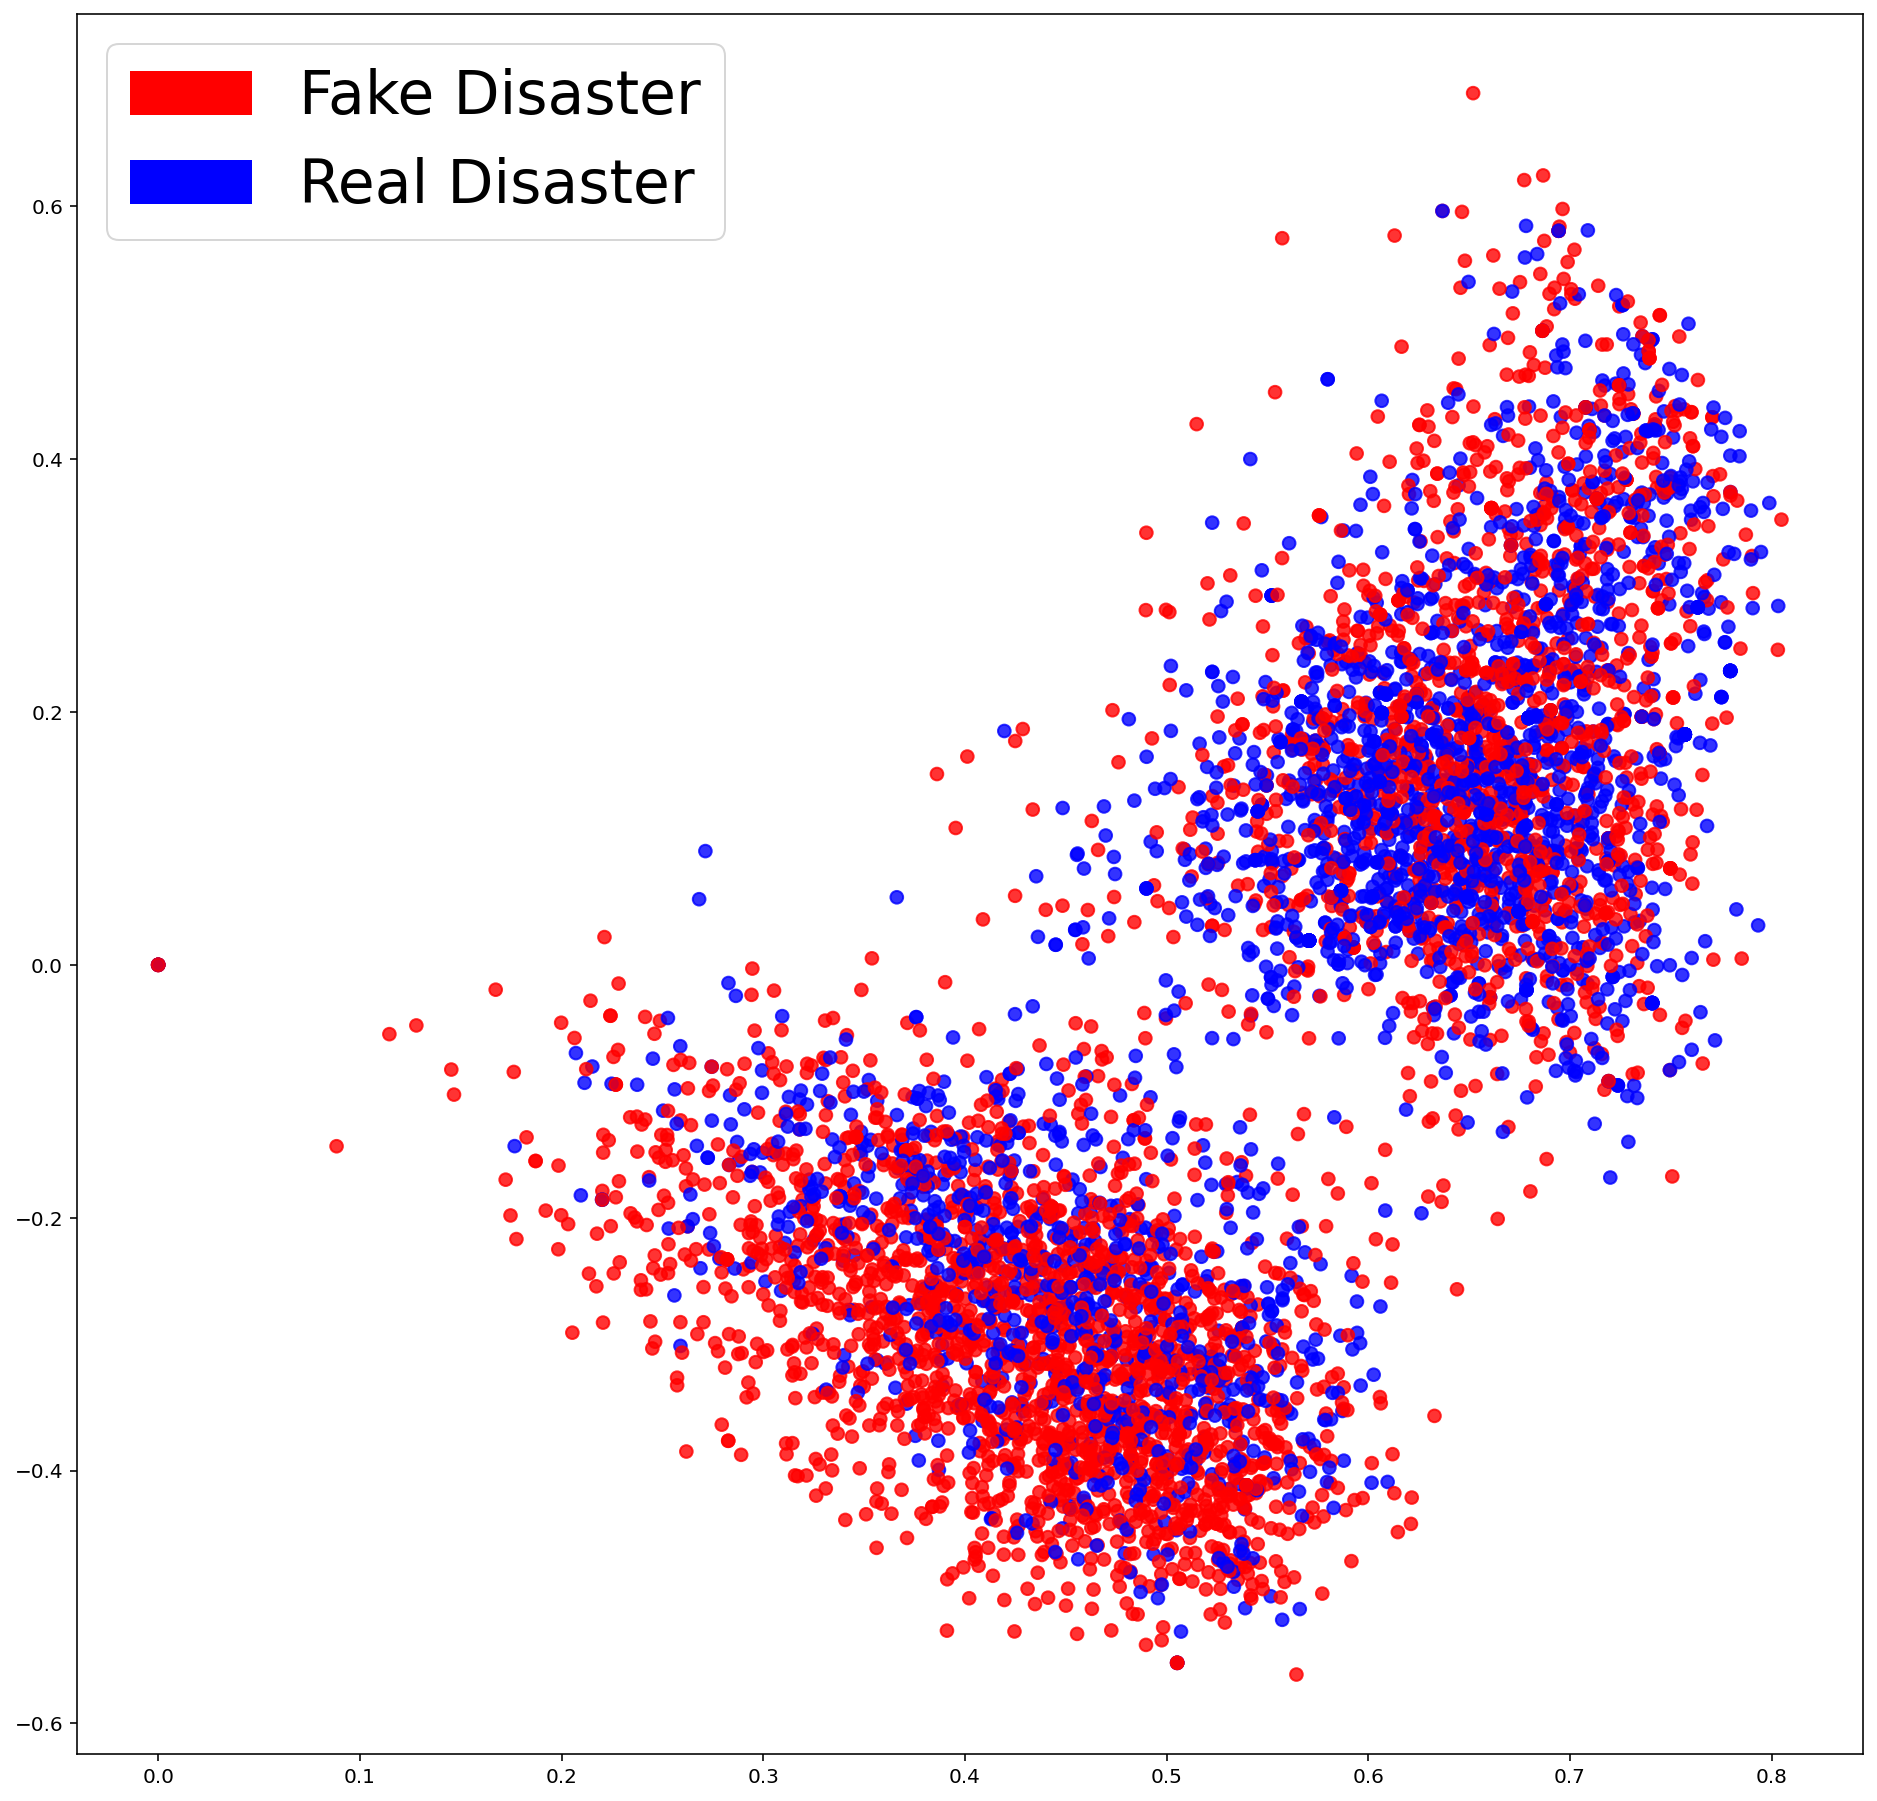

In [31]:
# plot the embeddings in 2D space
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_embeddings_lex, y_train)
plt.show()

Seems like the inter class differences increased by using LexVec embeddings. Now, it is more linearly separable.

In [32]:
#Evualte model
accuracy, db_in, sil_in = evaluate_embedding(X_train_embeddings_lex, y_train, X_test_embeddings_lex, y_test)
# Save results
data = {'model': 'LexVec', 'accuracy': accuracy, 'davies bouldin index':db_in, 'silhouette index':sil_in}
df_performance = df_performance.append(data, ignore_index=True)

              precision    recall  f1-score   support

        Fake       0.83      0.84      0.83       874
        Real       0.78      0.76      0.77       649

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



# Compare Different Models

1. Accuracy: Calculates the percentage of the correct predictions. 
2. Devis Bouldin Index: Evaluates intra-cluster similarity and inter-cluster differences. The minimum score is 0, with a lower value indicating better separation.
3. Silhouette Index: Measure the distance between each data point, the centroid of the cluster it was assigned to and the closest centroid belonging to another cluster. The value ranges between 1 and -1 when the best separation is indicated as 1, 0 indicates overlapping and worst is -1. Negative values generally indicate the wrong label. 

In [33]:
df_performance

model  accuracy  davies bouldin index  silhouette index
0  Word2Vec  0.802364              8.207780          0.013220
1     GloVe  0.625739             15.304236         -0.003525
2  FastText  0.799737              7.791694          0.012340
3    LexVec  0.807617              7.571519          0.014396

Analyzing the performance, it seems like other than Glove, every other model performed pretty well. However, the differences in the classification accuracy is not that significant. It should be reminded that the classification is very much dependent on the algorithm that has been chosen (i.e., logistic regression ). Choosing other classification algorithms (e.g., SVM, Random Forest ) or even tweaking the hyperparameters are likely to make a difference. Further investigation is needed to answer this. By considering all the metrics, it is clear that LexVec performed pretty well is class separation (i.e., detecting fake disaster tweets from the real disaster tweets). Again, the usage of the embeddings and the techniques is very much problem specific. It is difficult to say if a similar conclusion can be made from other problems. 